In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:
import numpy as np
import torch
import gymnasium as gym
from stable_baselines3 import A2C
from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.vec_env import DummyVecEnv

# === Setup Pendulum environment ===

# env = gym.make("HalfCheetah")
# env = gym.make("Ant")
# env = gym.make("Hopper")
# env = gym.make("Walker2d")
env = gym.make("Pendulum-v1")

In [6]:


dummy_env = DummyVecEnv([lambda: env])

model = A2C("MlpPolicy", dummy_env, verbose=0, device="cpu")

n_steps = 5
buffer = RolloutBuffer(
    buffer_size=n_steps,
    observation_space=env.observation_space,
    action_space=env.action_space,
    device=model.device,
    gamma=model.gamma,
    gae_lambda=model.gae_lambda,
)

# === Globals ===
step_count = 0
obs_last = None
action_last = None
value_last = None
log_prob_last = None

def reset_env():
    global obs_last
    obs_last = dummy_env.reset()
    return obs_last

def get_action(obs):
    global obs_last, action_last, value_last, log_prob_last
    obs_last = np.array(obs, dtype=np.float32).reshape((1, -1))
    obs_tensor = torch.tensor(obs_last).float().to(model.device)
    with torch.no_grad():
        action_tensor, value_tensor, log_prob_tensor = model.policy.forward(obs_tensor)
    action_last = action_tensor
    value_last = value_tensor
    log_prob_last = log_prob_tensor
    return action_tensor.cpu().numpy()[0]

def my_step(action):
    next_obs, reward, terminated, truncated, _ = env.step(np.array(action))
    done = terminated or truncated
    return next_obs, reward, done

def compute_a2c_loss(policy, rollout_data, value_coef=0.5, entropy_coef=0.01):
    observations = rollout_data.observations
    actions = rollout_data.actions
    returns = rollout_data.returns
    advantages = rollout_data.advantages
    old_log_probs = rollout_data.old_log_prob

    # Get action distribution and value predictions
    dist = policy.get_distribution(observations)
    value_preds = policy.predict_values(observations)

    # Log probs and entropy from the current policy
    new_log_probs = dist.log_prob(actions)
    entropy = dist.entropy().mean()

    # Actor loss
    policy_loss = -(advantages * new_log_probs).mean()

    # Critic loss
    value_loss = torch.nn.functional.mse_loss(returns, value_preds)

    # Total loss
    total_loss = policy_loss + value_coef * value_loss - entropy_coef * entropy
    return total_loss


def store_transition(reward, done, next_obs):
    global step_count, obs_last, action_last, value_last, log_prob_last
    reward = np.array([reward], dtype=np.float32)
    done = np.array([done], dtype=bool)
    next_obs = np.array(next_obs, dtype=np.float32).reshape((1, -1))
    buffer.add(obs_last, action_last, reward, done, value_last, log_prob_last)
    step_count += 1
    obs_last = next_obs
    if step_count % n_steps == 0:
        with torch.no_grad():
            last_val = model.policy.predict_values(torch.tensor(next_obs).float().to(model.device))

        buffer.compute_returns_and_advantage(last_val, dones=done)

        # Manual A2C training loop
        model.policy.train()
        model.policy.optimizer.zero_grad()
        for rollout_data in buffer.get(batch_size=None):
            loss = compute_a2c_loss(model.policy, rollout_data)
            loss.backward()
        model.policy.optimizer.step()

        buffer.reset()


def save_model(path="a2c_pendulum"):
    model.save(path)

def load_model(path="a2c_pendulum"):
    global model
    model = A2C.load(path)
    model.set_env(dummy_env)
    return True


In [7]:
import matplotlib.pyplot as plt

In [8]:
def train_multiple_episodes(n_episodes=100):

    for episode in range(n_episodes):
        global step_count
        obs = reset_env()
        done = False
        episode_reward = 0
        while not done:
            action = get_action(obs)
            next_obs, reward, done = my_step(action)
            store_transition(reward, done, next_obs)
            obs = next_obs
            print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, Total Steps = {step_count}")
            episode_reward += reward
            if done:
                break  # Optional, since the loop exits on `done` anyway
        step_count = 0  # Reset step count for the next episode
        print(f"Episode {episode + 1} finished with total reward: {episode_reward:.2f}")


In [9]:
train_multiple_episodes(10)

Episode 1: Reward = 0.00, Total Steps = 1
Episode 1: Reward = -5.10, Total Steps = 2
Episode 1: Reward = -10.16, Total Steps = 3
Episode 1: Reward = -15.46, Total Steps = 4
Episode 1: Reward = -21.21, Total Steps = 5
Episode 1: Reward = -27.60, Total Steps = 6
Episode 1: Reward = -34.78, Total Steps = 7
Episode 1: Reward = -43.00, Total Steps = 8
Episode 1: Reward = -52.32, Total Steps = 9
Episode 1: Reward = -62.80, Total Steps = 10
Episode 1: Reward = -73.34, Total Steps = 11
Episode 1: Reward = -82.93, Total Steps = 12
Episode 1: Reward = -91.58, Total Steps = 13
Episode 1: Reward = -99.18, Total Steps = 14
Episode 1: Reward = -105.73, Total Steps = 15
Episode 1: Reward = -111.42, Total Steps = 16
Episode 1: Reward = -116.47, Total Steps = 17
Episode 1: Reward = -121.14, Total Steps = 18
Episode 1: Reward = -125.62, Total Steps = 19
Episode 1: Reward = -130.05, Total Steps = 20
Episode 1: Reward = -134.58, Total Steps = 21
Episode 1: Reward = -139.43, Total Steps = 22
Episode 1: Rew

C:\Users\deols\AppData\Local\Temp\ipykernel_22384\688301158.py:62: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = torch.nn.functional.mse_loss(returns, value_preds)


Episode 2: Reward = -603.49, Total Steps = 65
Episode 2: Reward = -612.63, Total Steps = 66
Episode 2: Reward = -621.93, Total Steps = 67
Episode 2: Reward = -631.29, Total Steps = 68
Episode 2: Reward = -640.69, Total Steps = 69
Episode 2: Reward = -650.13, Total Steps = 70
Episode 2: Reward = -659.61, Total Steps = 71
Episode 2: Reward = -669.13, Total Steps = 72
Episode 2: Reward = -678.66, Total Steps = 73
Episode 2: Reward = -688.22, Total Steps = 74
Episode 2: Reward = -697.78, Total Steps = 75
Episode 2: Reward = -707.34, Total Steps = 76
Episode 2: Reward = -716.84, Total Steps = 77
Episode 2: Reward = -726.28, Total Steps = 78
Episode 2: Reward = -735.73, Total Steps = 79
Episode 2: Reward = -745.24, Total Steps = 80
Episode 2: Reward = -754.73, Total Steps = 81
Episode 2: Reward = -764.20, Total Steps = 82
Episode 2: Reward = -773.60, Total Steps = 83
Episode 2: Reward = -782.89, Total Steps = 84
Episode 2: Reward = -792.15, Total Steps = 85
Episode 2: Reward = -801.39, Total

In [10]:
episode_rewards = []
episode_steps = []
n_episodes = 100


In [11]:
for episode in range(n_episodes):
    obs = reset_env()
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = get_action(obs)
        next_obs, reward, done = my_step(action)
        store_transition(reward, done, next_obs)
        obs = next_obs
        total_reward += reward
        steps += 1
    episode_rewards.append(total_reward)
    episode_steps.append(steps)
    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}, Steps = {steps}")


C:\Users\deols\AppData\Local\Temp\ipykernel_22384\688301158.py:62: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = torch.nn.functional.mse_loss(returns, value_preds)


Episode 1: Total Reward = -1452.04, Steps = 200
Episode 2: Total Reward = -1822.12, Steps = 200
Episode 3: Total Reward = -1814.97, Steps = 200
Episode 4: Total Reward = -1676.35, Steps = 200
Episode 5: Total Reward = -1720.46, Steps = 200
Episode 6: Total Reward = -1730.26, Steps = 200
Episode 7: Total Reward = -1652.96, Steps = 200
Episode 8: Total Reward = -1752.39, Steps = 200
Episode 9: Total Reward = -1153.52, Steps = 200
Episode 10: Total Reward = -1203.27, Steps = 200
Episode 11: Total Reward = -1559.06, Steps = 200
Episode 12: Total Reward = -1808.16, Steps = 200
Episode 13: Total Reward = -1316.52, Steps = 200
Episode 14: Total Reward = -1342.25, Steps = 200
Episode 15: Total Reward = -1187.63, Steps = 200
Episode 16: Total Reward = -1276.94, Steps = 200
Episode 17: Total Reward = -1441.18, Steps = 200
Episode 18: Total Reward = -1556.69, Steps = 200
Episode 19: Total Reward = -1829.66, Steps = 200
Episode 20: Total Reward = -1502.03, Steps = 200
Episode 21: Total Reward = -1

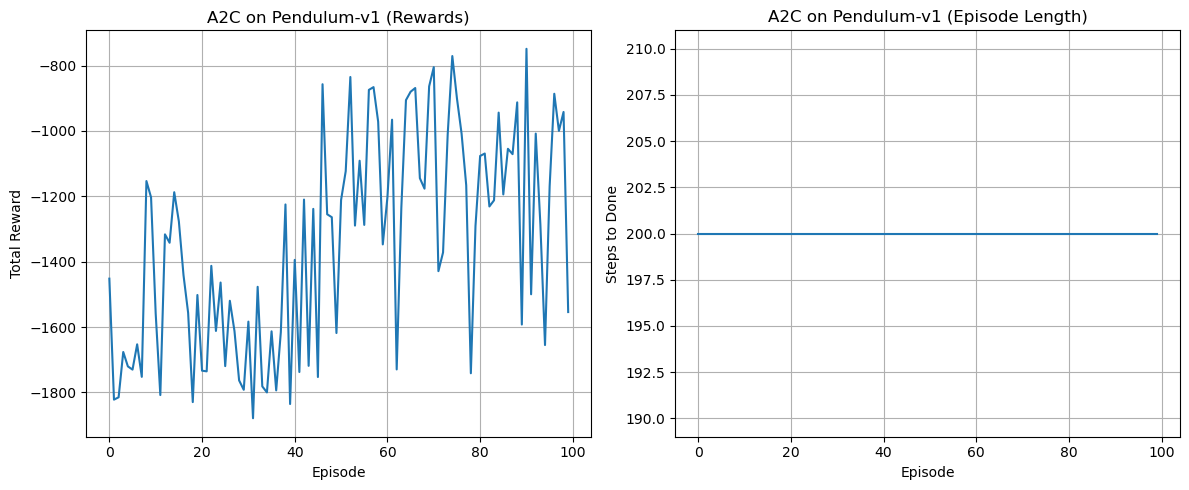

In [12]:
# === Plot the rewards and steps ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("A2C on Pendulum-v1 (Rewards)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(episode_steps)
plt.xlabel("Episode")
plt.ylabel("Steps to Done")
plt.title("A2C on Pendulum-v1 (Episode Length)")
plt.grid(True)

plt.tight_layout()
plt.show()
